# EY NextWave Data Science Competition 2019 - Clustering

- <a href='#1'>1. Introduction</a>  
    - <a href='#1-1'>1.1. Problem Statement</a>
- <a href='#2'>2. General Overview </a>
- <a href='#3'>3. Importing Libraries and Data </a>
- <a href='#4'> 4. Feature Extraction</a>
    - <a href='#4-1'> 4.1. Distancial-directional Calculations</a>
- <a href='#7'> 7. Baseline Models </a>
    - <a href='#7-1'> 7.1. Logistic Regression</a>
    - <a href='#7-2'> 7.2. Random Forest</a>
    - <a href='#7-3'> 7.3. Gradient Boosting</a>
    - <a href='#7-4'> 7.4. Feature Importances </a>
- <a href='#9'> 9. Saving Train and Test Set preprocessed  </a>
- <a href='#10'> 10. Conclusion </a>

## <a id='1'>1. Importing Libraries and Data</a>

In [8]:
# !pip install tqdm
# !conda install shapely descartes geopandas lightgbm -y

In [57]:
import warnings
import math
import re

# visualiztion tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

# data preprocessing tools
import pandas as pd
from shapely.geometry import Point
import numpy as np


tqdm.pandas()
plt.style.use('seaborn')
warnings.filterwarnings("ignore")

%run ../src/utils.py

In [2]:
data = pd.read_hdf('../data/preprocessed/data_sequence.hdf', key='final')

train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)

train_data = data[data.hash.isin(train.hash)]
test_data = data[data.hash.isin(test.hash)]

train_data.shape, test_data.shape

((110701, 1083), (33515, 1083))

## <a id='1'>2. Clustering</a>
Based on sequence data obtained through analysis and feature engineering, we'll explore clustering results for our train set.

In [10]:
cluster_cols = []
window_reference = 5

non_leaking = ['timedelta',
               'x_entry',
               'y_entry',
               'lon_entry',
               'lat_entry',
               'manh_dist_cc_entry',
               'havr_dist_cc_entry',
               *[f'distance_{side}_latlon_border' for side in ['lower', 'upper', 'right', 'left']]]

leaking = ['center_permanency']

for col in non_leaking:
    cluster_cols += [f'{col}_{i}' for i in range(1, window_reference+1)]

for col in leaking:
    cluster_cols += [f'{col}_{i}' for i in range(1, window_reference)]

cluster_cols = list(set(cluster_cols))

### <a id='2-1'>2.1. Elbow Method</a>

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_data[cluster_cols].fillna(0))

wcss = [] # within-cluster sum of squares
k_cluster_range = range(1, 30)
kmeans_train_data = scaler.transform(train_data[cluster_cols].fillna(0))

for i in k_cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=20)
    kmeans.fit(kmeans_train_data)
    print('k = {}\t{}'.format(i, kmeans.inertia_))
    wcss.append(kmeans.inertia_)

k = 1	6531359.0
k = 2	4619760.645186661
k = 3	3876791.974856032
k = 4	3375002.384256769
k = 5	3030876.7624419583
k = 6	2712440.272496589
k = 7	2583333.3285960793
k = 8	2459258.222549103
k = 9	2361368.795597577
k = 10	2258572.8635709155
k = 11	2172708.5158315906
k = 12	2095550.53492767
k = 13	2015139.8548253956
k = 14	1937559.4490381975
k = 15	1880208.6250924957
k = 16	1823146.3418029079
k = 17	1782447.1121815864
k = 18	1738732.1080805873
k = 19	1696440.6301329008
k = 20	1660356.3996618
k = 21	1646566.4803352915
k = 22	1612141.7169756244
k = 23	1578505.6022328075
k = 24	1559064.381993704
k = 25	1536001.9456884728
k = 26	1516528.6586489372
k = 27	1504575.9593203273
k = 28	1486574.8582431884
k = 29	1464813.0216770377


Text(0,0.5,'Sum of squared errors (WCSS)')

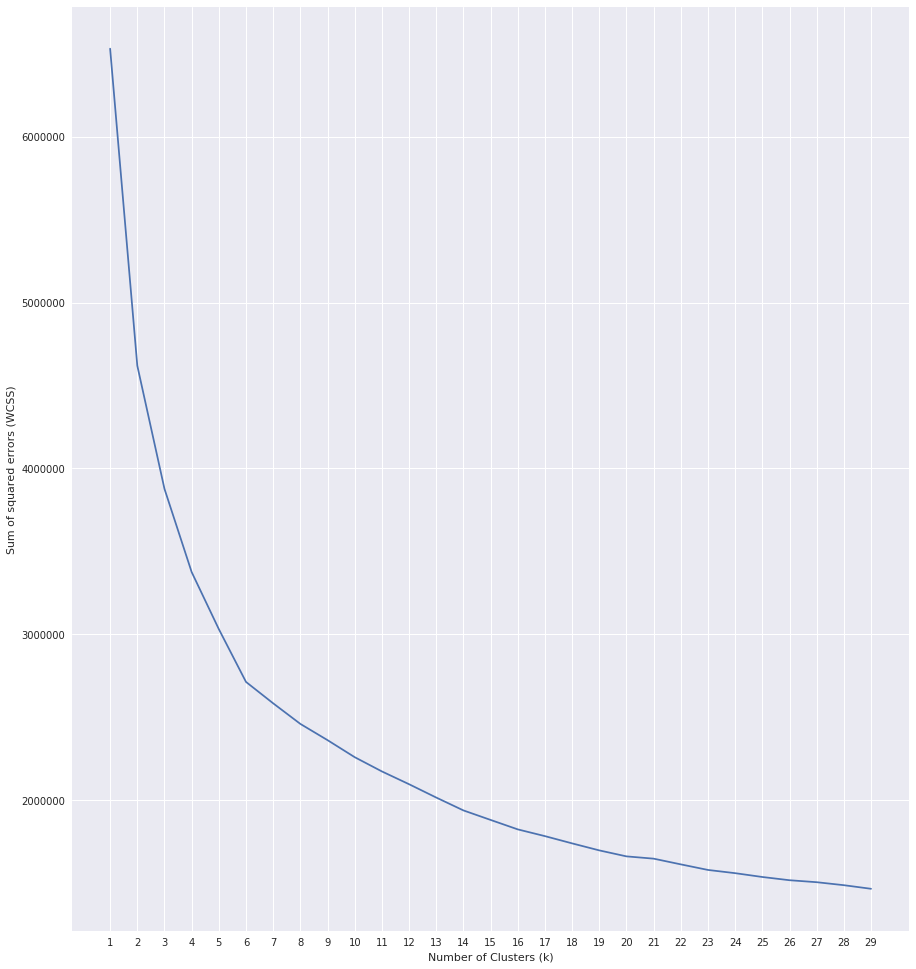

In [13]:
fig = plt.figure(figsize=(15, 17))
plt.plot(k_cluster_range, wcss)
plt.xticks(np.arange(1, 30, step=1))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of squared errors (WCSS)')

From the above we can conclude the best `k` to be `k = 6`, the value which defines the very elbow of our squared error projection.

Let us now prepare cluster data for initial geographical visualization.

In [14]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=20)
kmeans.fit(kmeans_train_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=20, tol=0.0001, verbose=0)

In [15]:
kmeans.labels_

array([0, 1, 4, ..., 3, 1, 4], dtype=int32)

In [16]:
len(kmeans.labels_), train_data.shape[0]

(110701, 110701)

In [17]:
train_data['cluster'] = kmeans.labels_

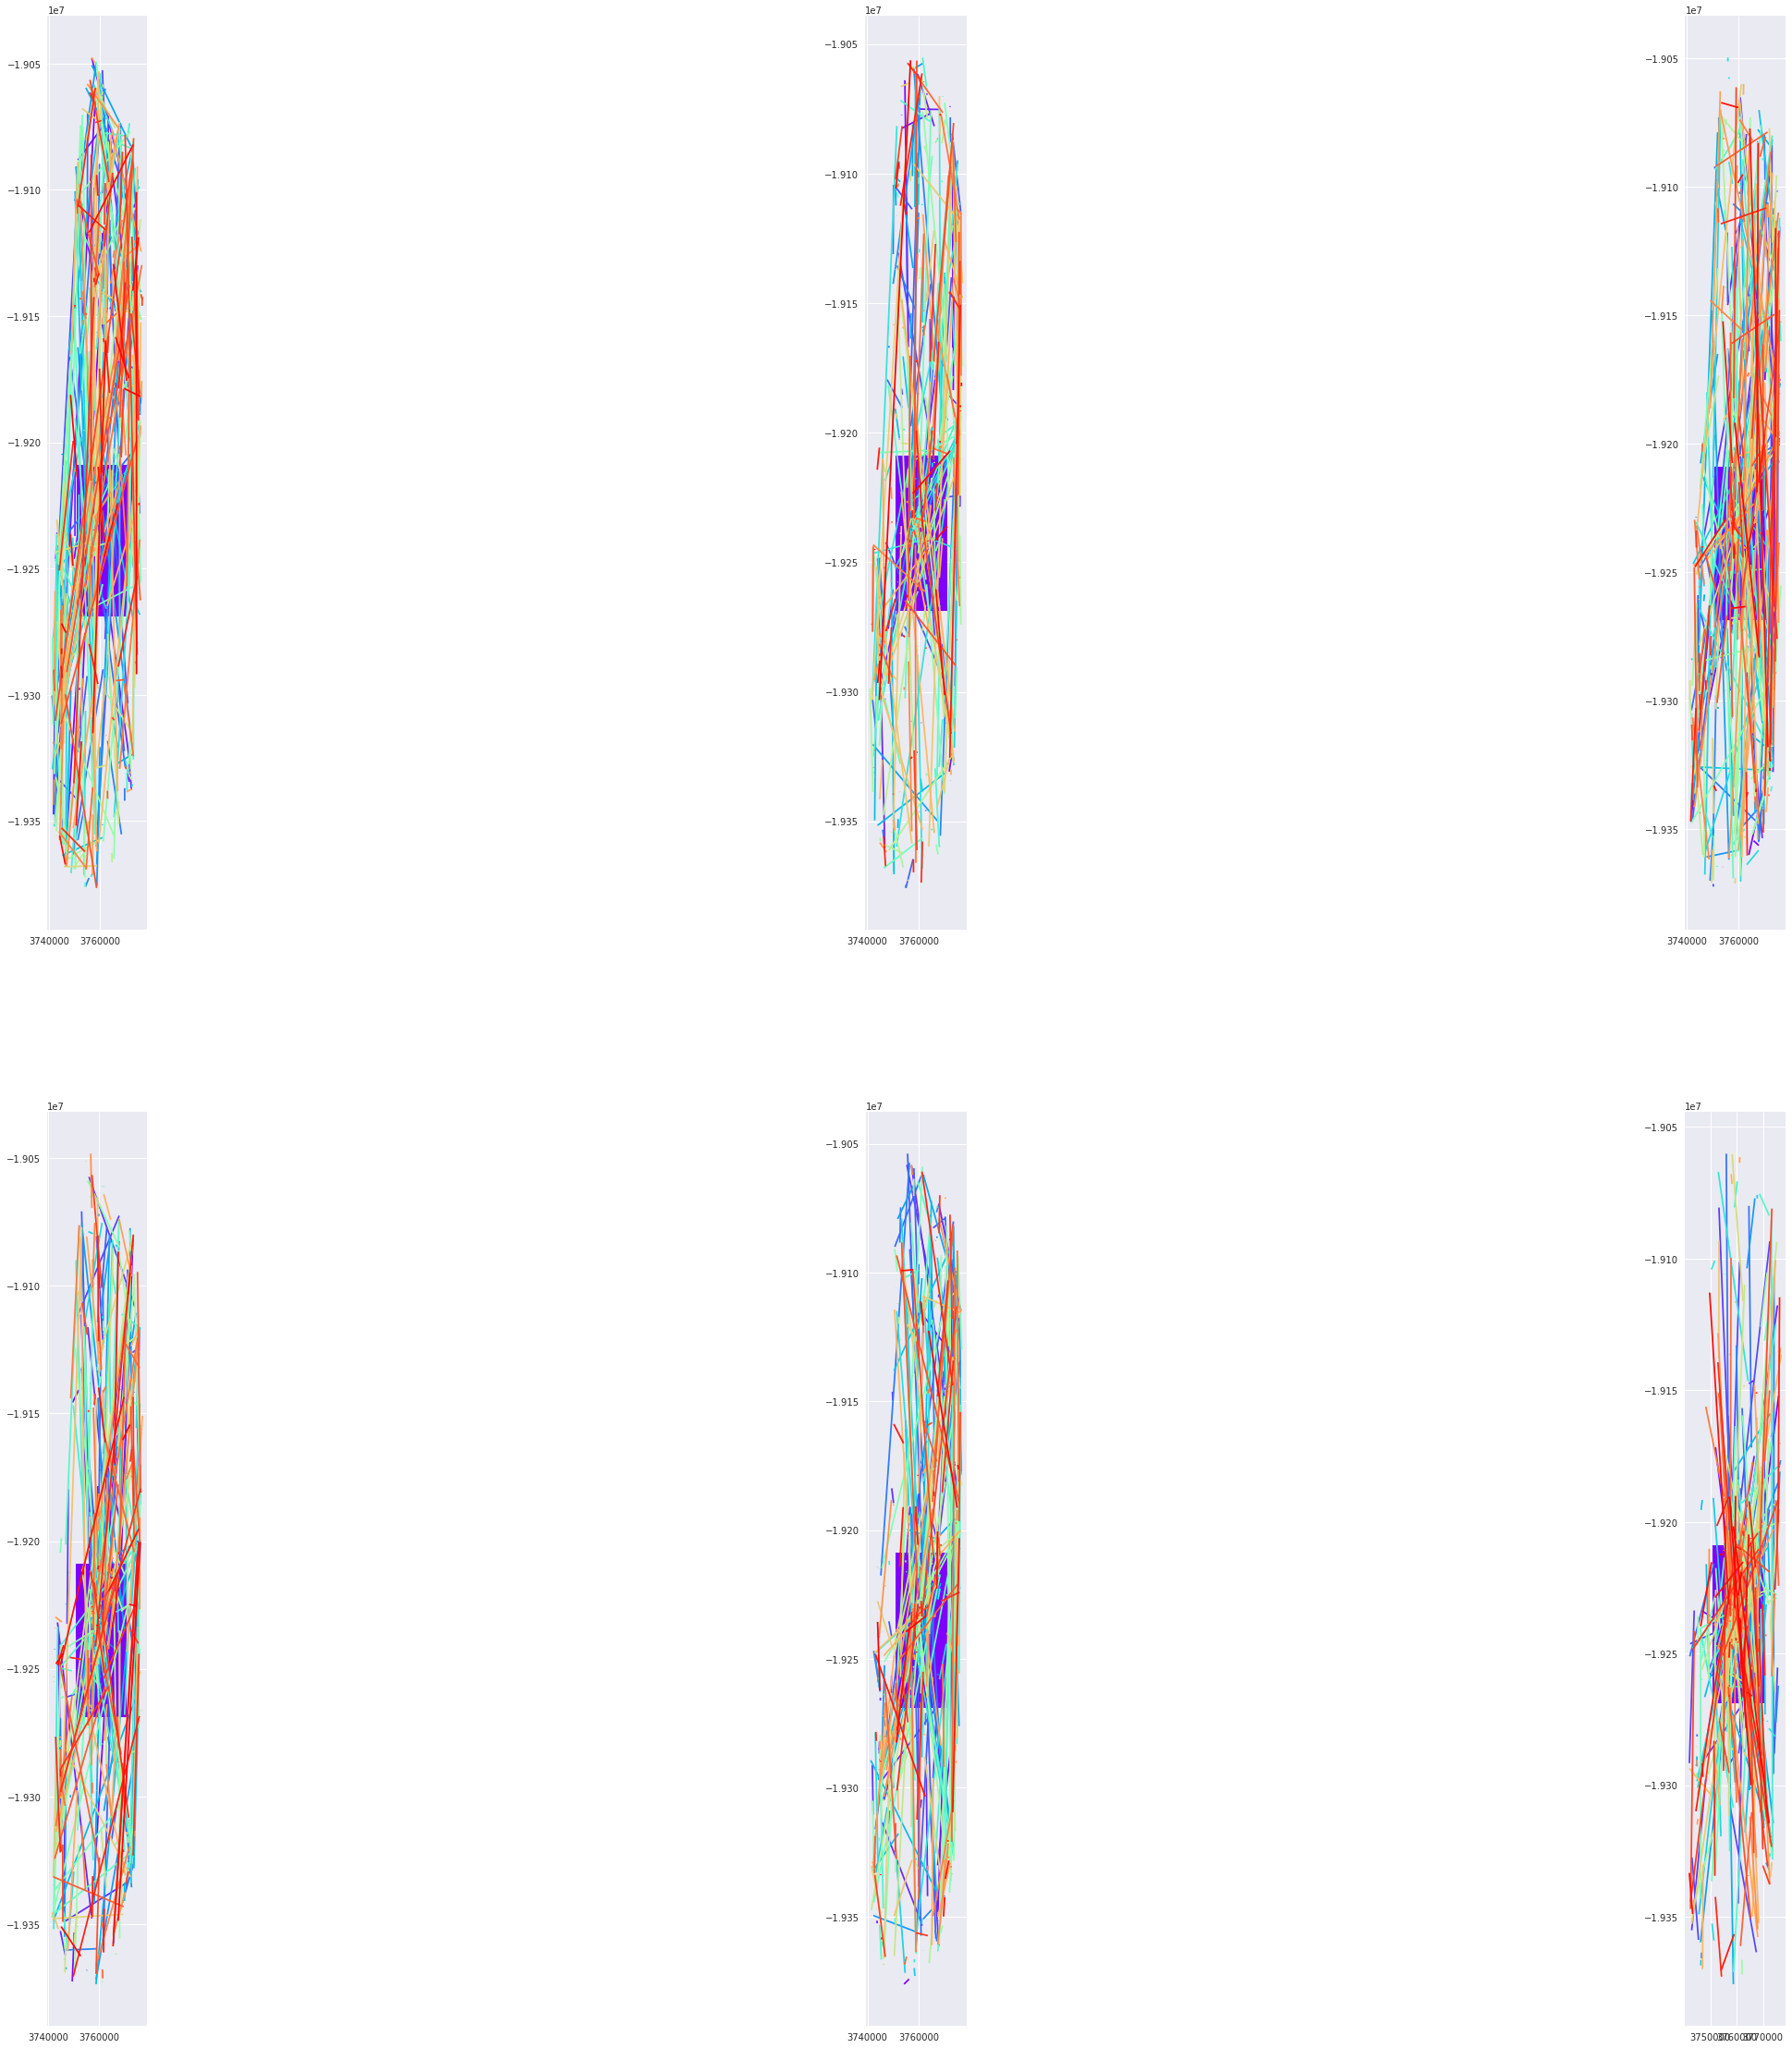

In [61]:
trajectory_count = 600

ncols = min(k, 3)
nrows = 1 if k <= 3 else math.ceil(k/3)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(45, 40))

cluster_range = list(range(0, k))
clusterlist = [train_data[train_data.cluster == i] for i in cluster_range]

for ax, c in zip(axes.reshape(-1)[0:k], clusterlist):
    geoplot(c.tail(trajectory_count), ax=ax, window_reference=window_reference, filter_by_time=False)

### <a id='2-2'>2.2. Cluster Analysis</a>

In [63]:
list({'cluster_{}_mean_dist'.format(i): c.havr_dist_cc_entry_5.mean()} for i, c in enumerate(clusterlist))

[{'cluster_0_mean_dist': 709.3342826515463},
 {'cluster_1_mean_dist': 621.3348243713258},
 {'cluster_2_mean_dist': 565.6073604358365},
 {'cluster_3_mean_dist': 574.8435138988607},
 {'cluster_4_mean_dist': 581.3459616580948},
 {'cluster_5_mean_dist': 331.6003384256832}]

In [68]:
arr = lambda: np.empty([len(clusterlist)]).tolist()

dist_col = f'havr_dist_cc_entry_{window_reference}'
is_inside_city_entry = f'is_inside_city_entry_{window_reference}'
is_inside_city_exit = f'is_inside_city_exit_{window_reference}'

longest, shortest = arr(), arr()
short_staying_in, short_staying_out = arr(), arr()
short_leaving_center, short_entering_center = arr(), arr()
long_staying_in, long_staying_out = arr(), arr()
long_leaving_center, long_entering_center = arr(), arr()

for i, c in enumerate(clusterlist):
    longest[i] = c.sort_values(dist_col, ascending=False).head(c.shape[0]//2).copy()
    shortest[i] = c.sort_values(dist_col, ascending=True).head(c.shape[0]//2).copy()

    short_staying_in[i] = shortest[i][(shortest[i][is_inside_city_entry] == 1) & (shortest[i][is_inside_city_exit] == 1)]
    short_staying_out[i] = shortest[i][(shortest[i][is_inside_city_entry] == 0) & (shortest[i][is_inside_city_exit] == 0)]
    short_leaving_center[i] = shortest[i][(shortest[i][is_inside_city_entry] == 1) & (shortest[i][is_inside_city_exit] == 0)]
    short_entering_center[i] = shortest[i][(shortest[i][is_inside_city_entry] == 0) & (shortest[i][is_inside_city_exit] == 1)]

    long_staying_in[i] = longest[i][(longest[i][is_inside_city_entry] == 1) & (longest[i][is_inside_city_exit] == 1)]
    long_staying_out[i] = longest[i][(longest[i][is_inside_city_entry] == 0) & (longest[i][is_inside_city_exit] == 0)]
    long_leaving_center[i] = longest[i][(longest[i][is_inside_city_entry] == 1) & (longest[i][is_inside_city_exit] == 0)]
    long_entering_center[i] = longest[i][(longest[i][is_inside_city_entry] == 0) & (longest[i][is_inside_city_exit] == 1)]

In [73]:
def cluster_plot(i, short_qtt=500, long_qtt=500):
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(ncols=4, nrows=2, figsize=(30, 40))
    
    qtt_for_sample = lambda sample, qtt: qtt if qtt <= sample.shape[0] else sample.shape[0]
    geo = lambda sample, ax: geoplot(sample, ax=ax, filter_by_time=False, window_reference=window_reference)

    ax_font = 20
    fig.suptitle('Cluster {}'.format(i+1), fontsize=25)

    # Shortest
    shortest_len = len(shortest[i])
    short_probs = [
        100 * len(short_staying_in[i]) / shortest_len,
        100 * len(short_staying_out[i]) / shortest_len,
        100 * len(short_entering_center[i]) / shortest_len,
        100 * len(short_leaving_center[i]) / shortest_len
    ]
    
    ax1.set_title('Staying in center: {:.3f}%'.format(short_probs[0]), fontsize=ax_font)
    if short_probs[0] > 0.0 and short_staying_in[i].shape[0] != 0:
        geo(short_staying_in[i].head(qtt_for_sample(short_staying_in[i], short_qtt)), ax1)
    
    ax2.set_title('Staying out of center: {:.3f}%'.format(short_probs[1]), fontsize=ax_font)
    if short_probs[1] > 0.0 and short_staying_out[i].shape[0] != 0:
        geo(short_staying_out[i].head(qtt_for_sample(short_staying_out[i], short_qtt)), ax2)
    
    ax3.set_title('Entering: {:.3f}%'.format(short_probs[2]), fontsize=ax_font)
    if short_probs[2] > 0.0 and short_entering_center[i].shape[0] != 0:
        geo(short_entering_center[i].head(qtt_for_sample(short_entering_center[i], short_qtt)), ax3)
    
    ax4.set_title('Leaving: {:.3f}%'.format(short_probs[3]), fontsize=ax_font)
    if short_probs[3] > 0.0 and short_leaving_center[i].shape[0] != 0:
        geo(short_leaving_center[i].head(qtt_for_sample(short_leaving_center[i], short_qtt)), ax4)

    # Longest
    longest_len = len(longest[i])
    long_probs = [
        100 * len(long_staying_in[i]) / longest_len,
        100 * len(long_staying_out[i]) / longest_len,
        100 * len(long_entering_center[i]) / longest_len,
        100 * len(long_leaving_center[i]) / longest_len
    ]
    
    ax5.set_title('Staying in center: {:.3f}%'.format(long_probs[0]), fontsize=ax_font)
    if long_probs[0] > 0.0 and long_staying_in[i].shape[0] != 0:
        geo(long_staying_in[i].head(qtt_for_sample(long_staying_in[i], long_qtt)), ax5)
    
    ax6.set_title('Staying out of center: {:.3f}%'.format(long_probs[1]), fontsize=ax_font)
    if long_probs[1] > 0.0 and long_staying_out[i].shape[0] != 0:
        geo(long_staying_out[i].head(qtt_for_sample(long_staying_out[i], long_qtt)), ax6)
    
    ax7.set_title('Entering: {:.3f}%'.format(long_probs[2]), fontsize=ax_font)
    if long_probs[2] > 0.0 and long_entering_center[i].shape[0] != 0:
        geo(long_entering_center[i].head(qtt_for_sample(long_entering_center[i], long_qtt)), ax7)
    
    ax8.set_title('Leaving: {:.3f}%'.format(long_probs[3]), fontsize=ax_font)
    if long_probs[3] > 0.0 and long_leaving_center[i].shape[0] != 0:
        geo(long_leaving_center[i].head(qtt_for_sample(long_leaving_center[i], long_qtt)), ax8)

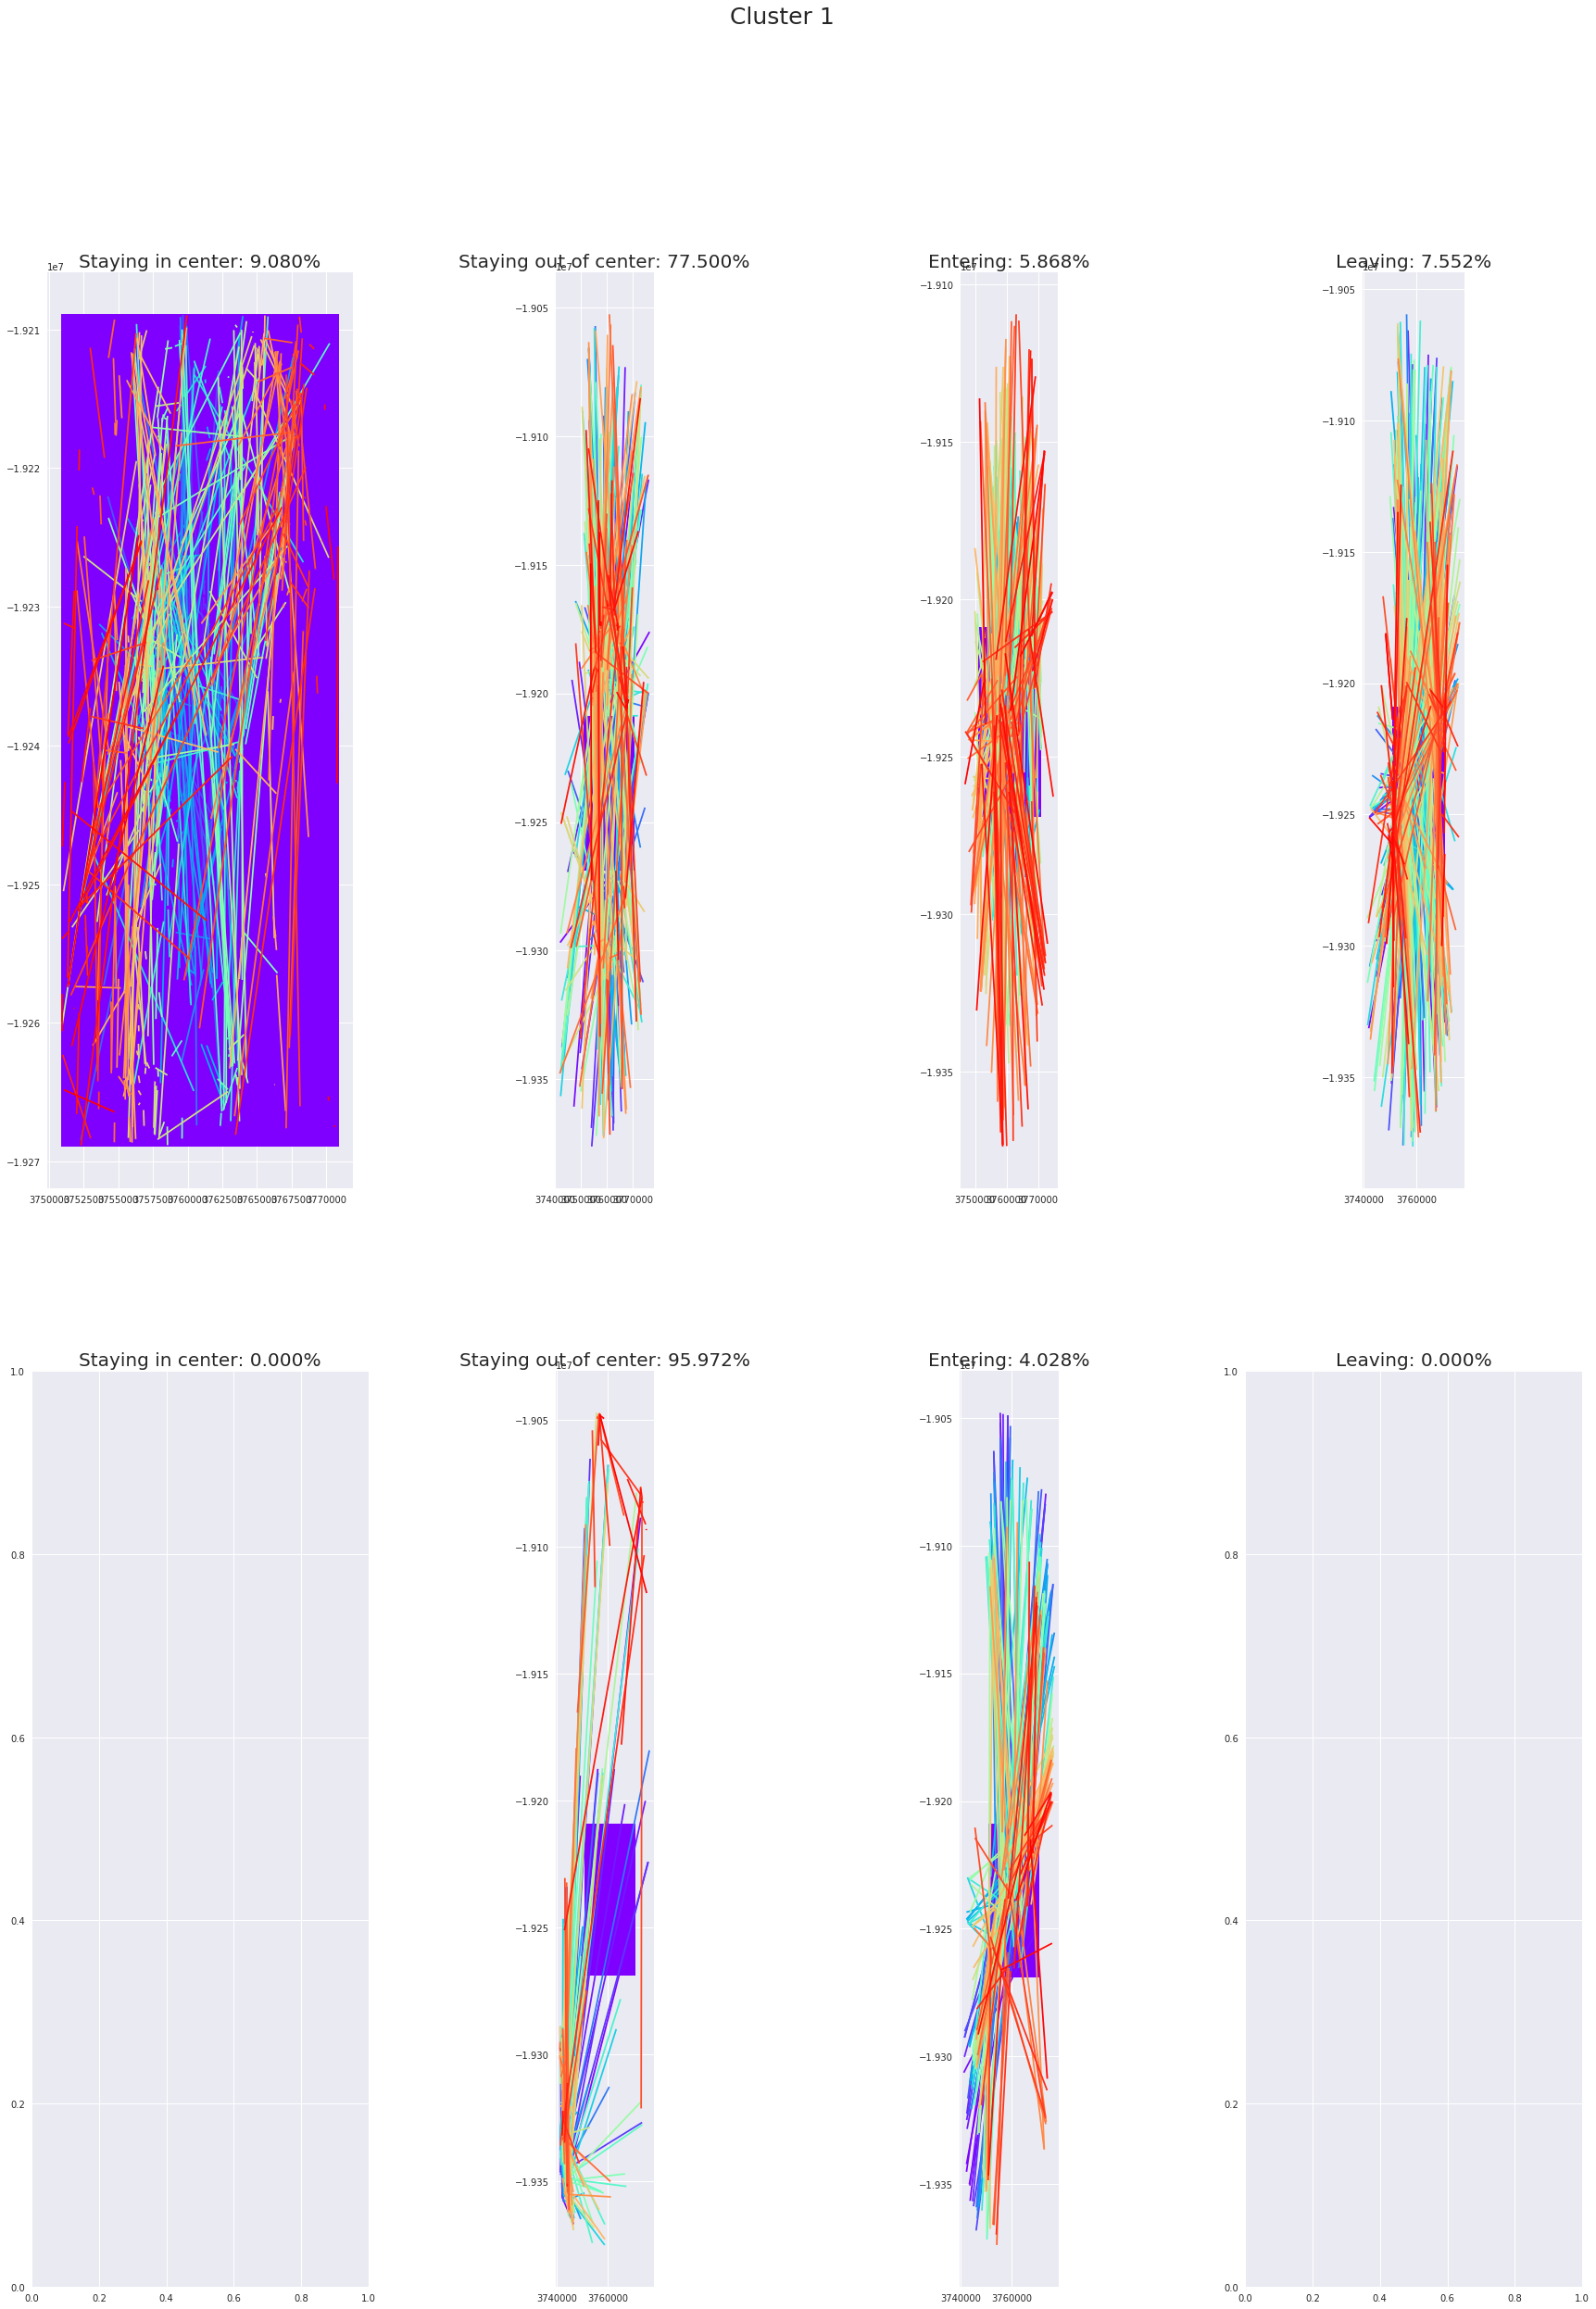

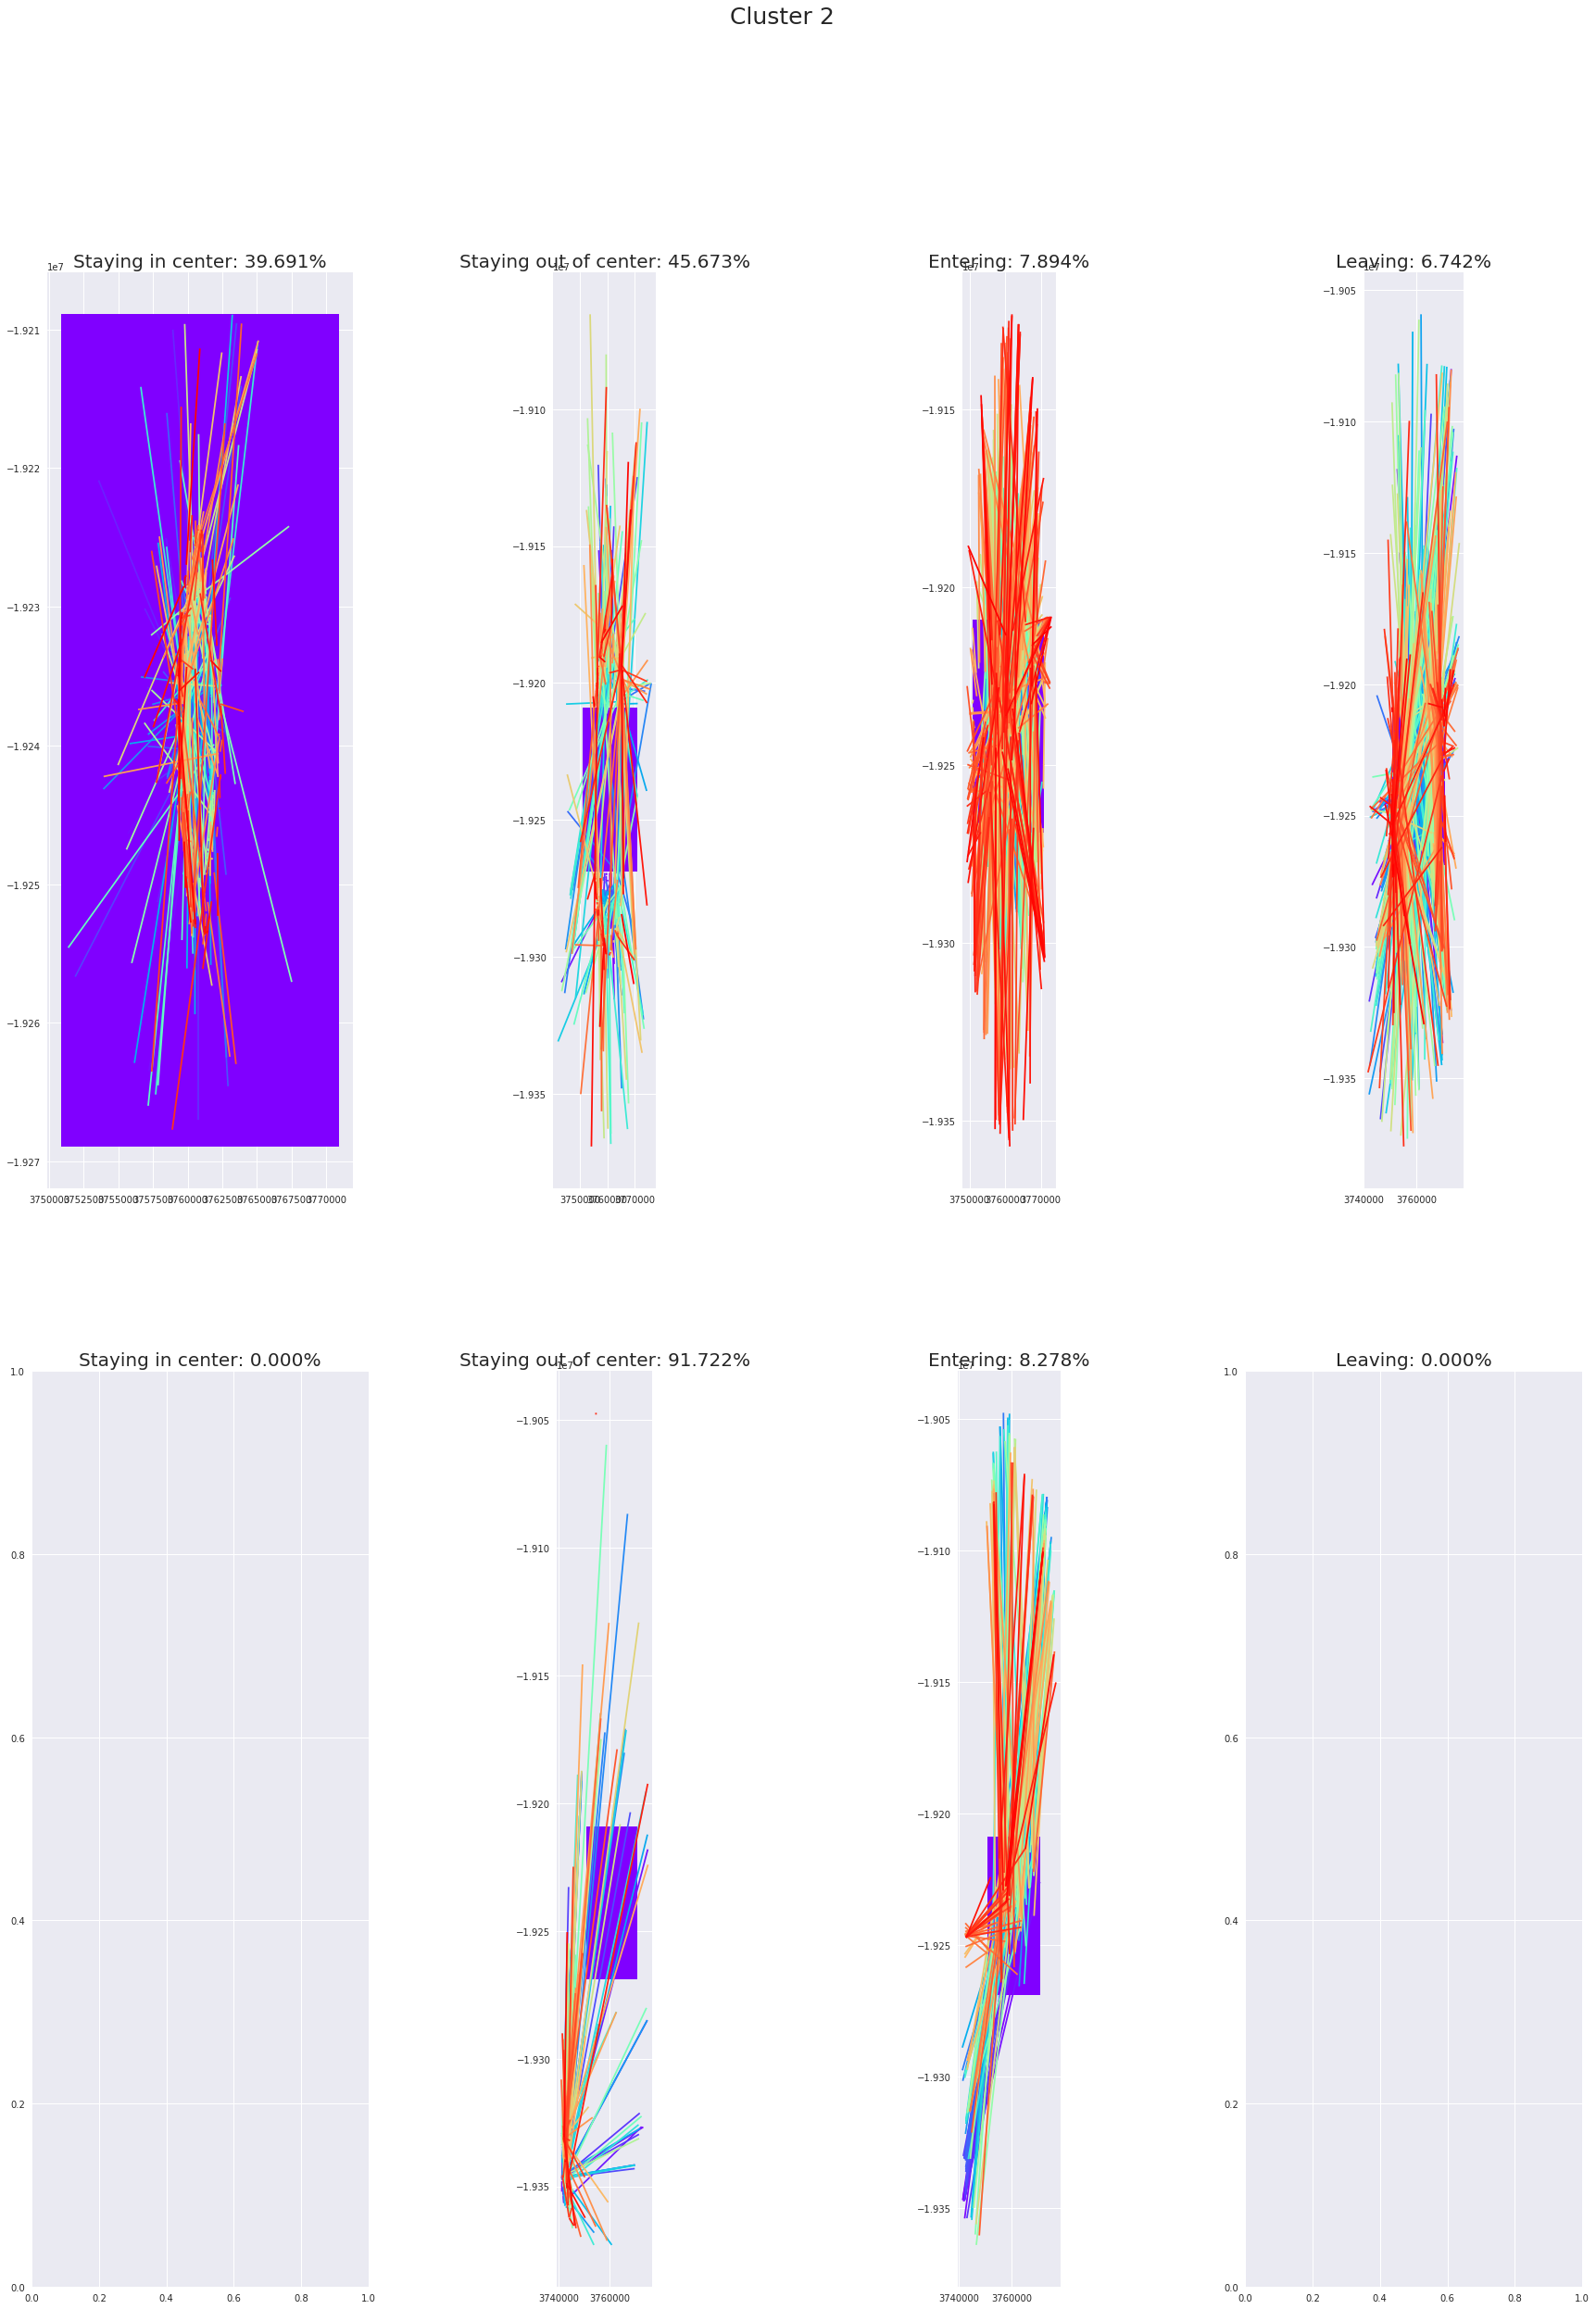

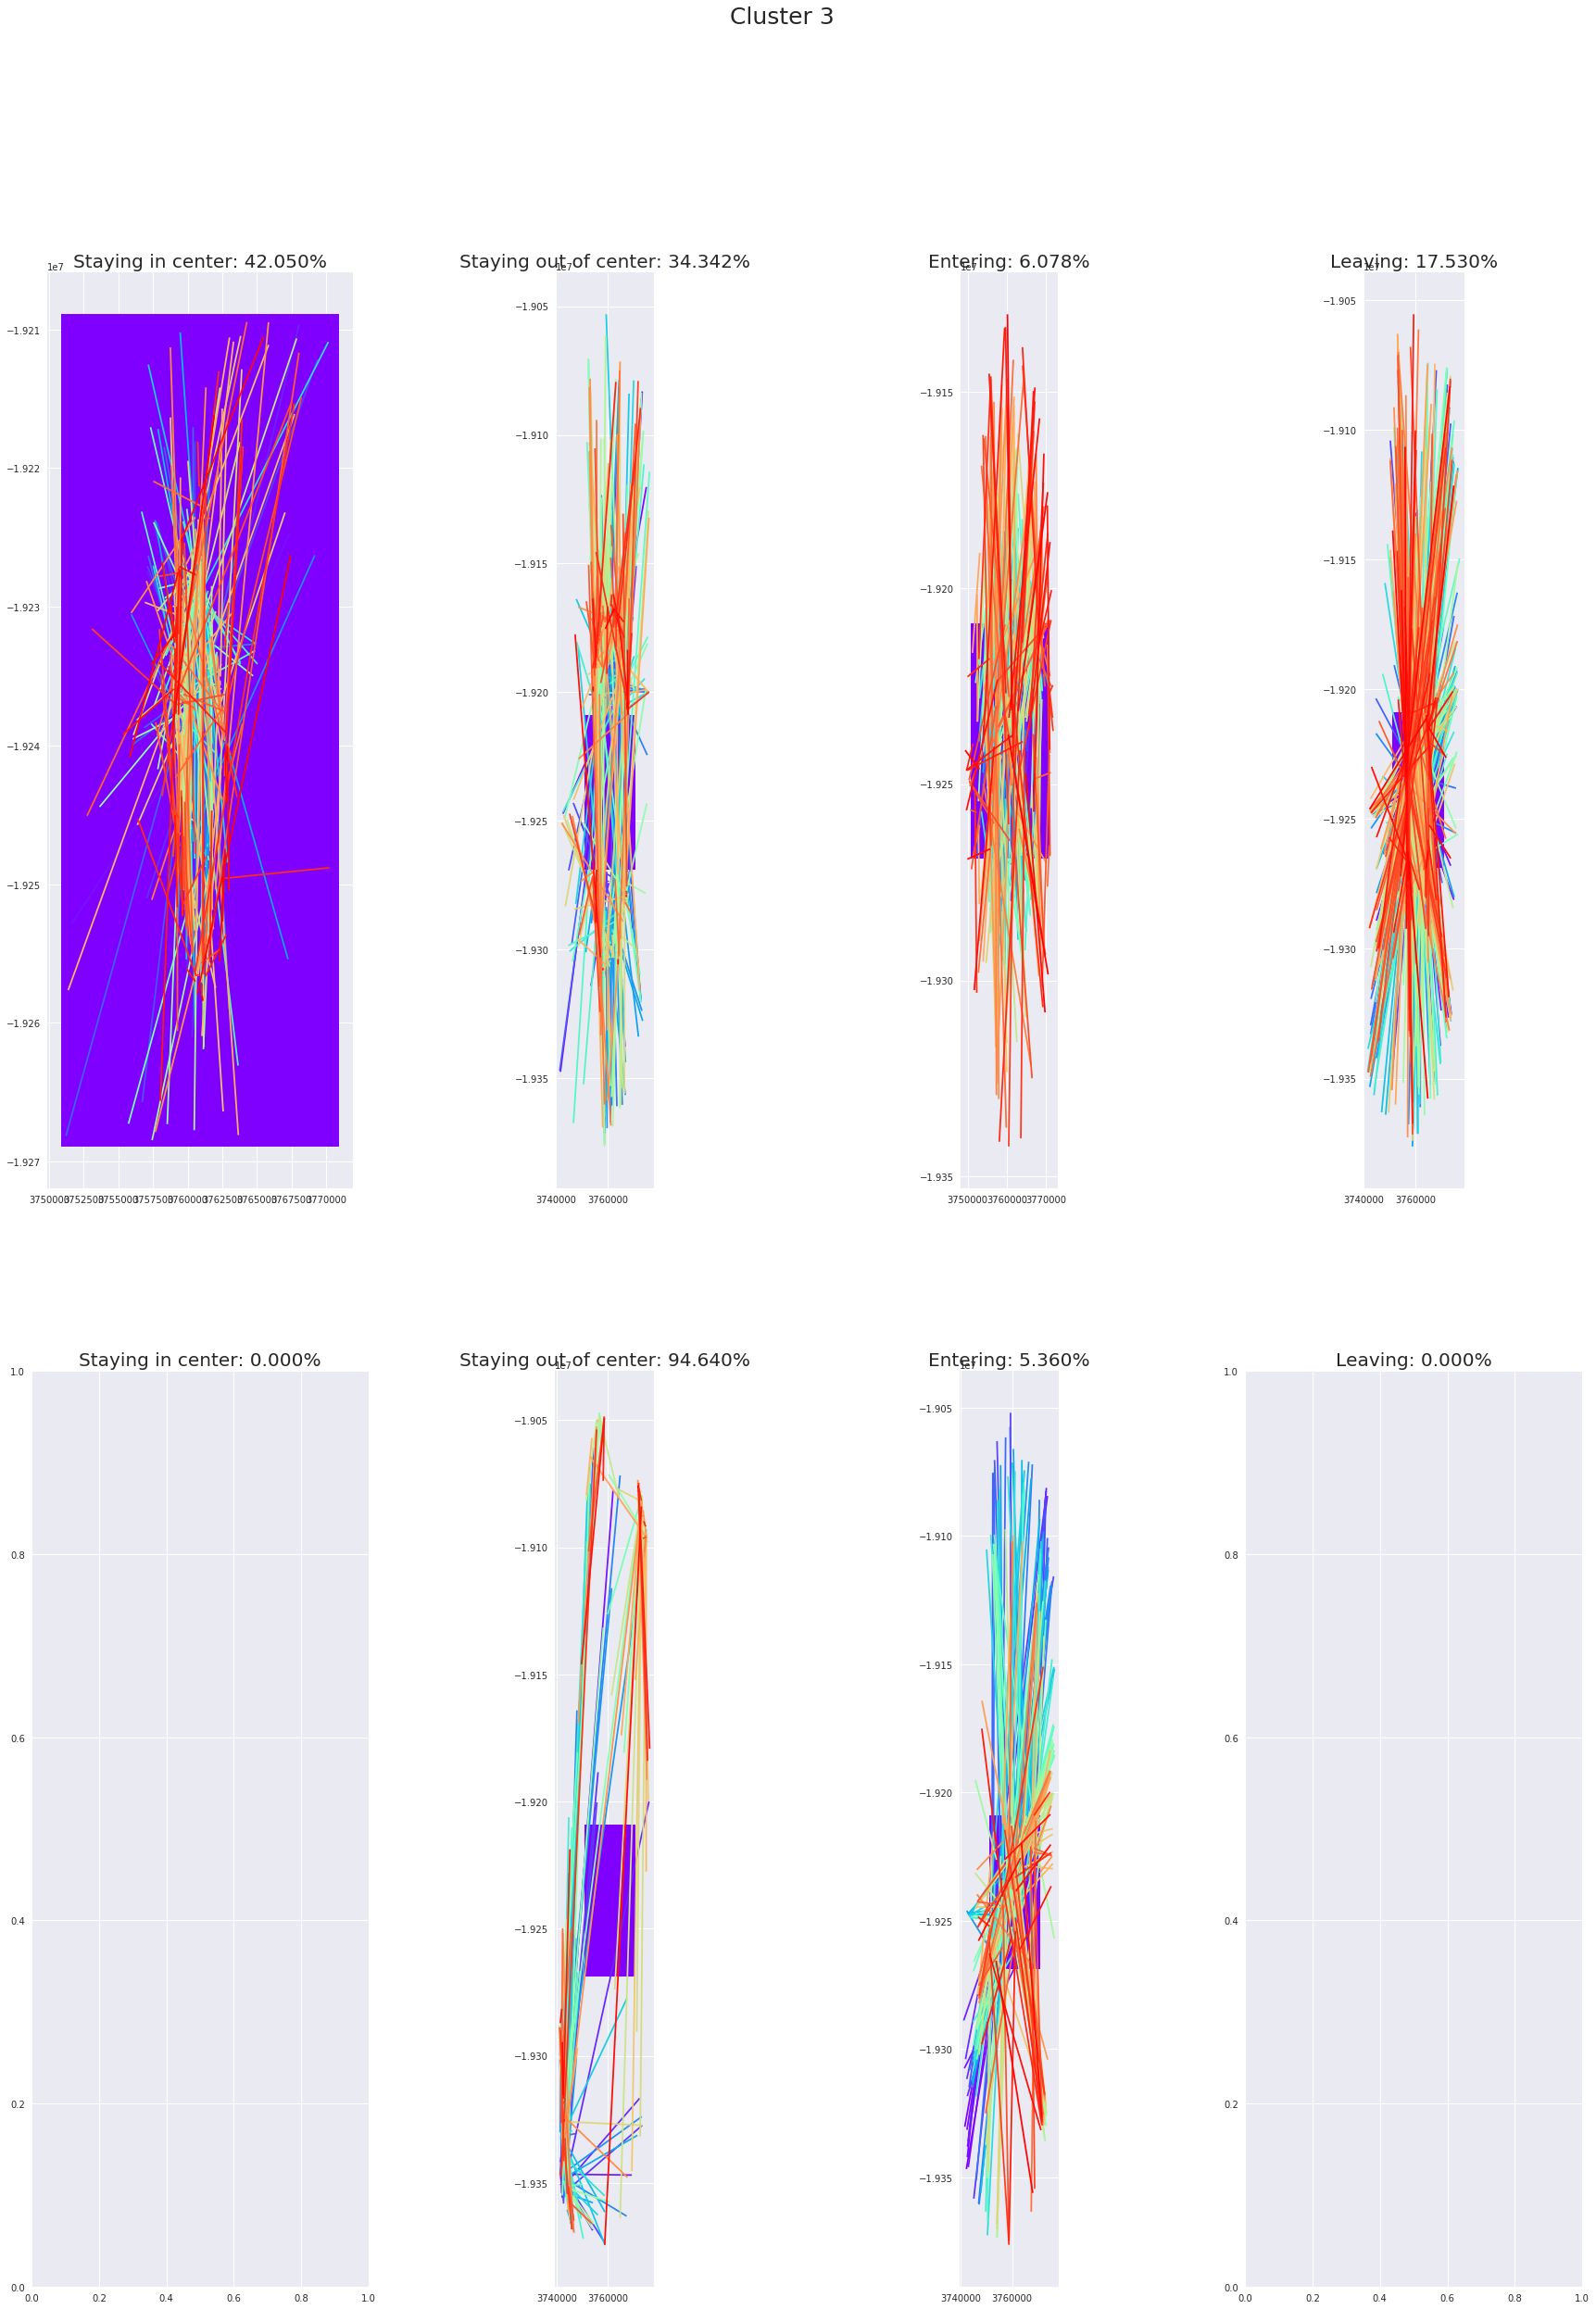

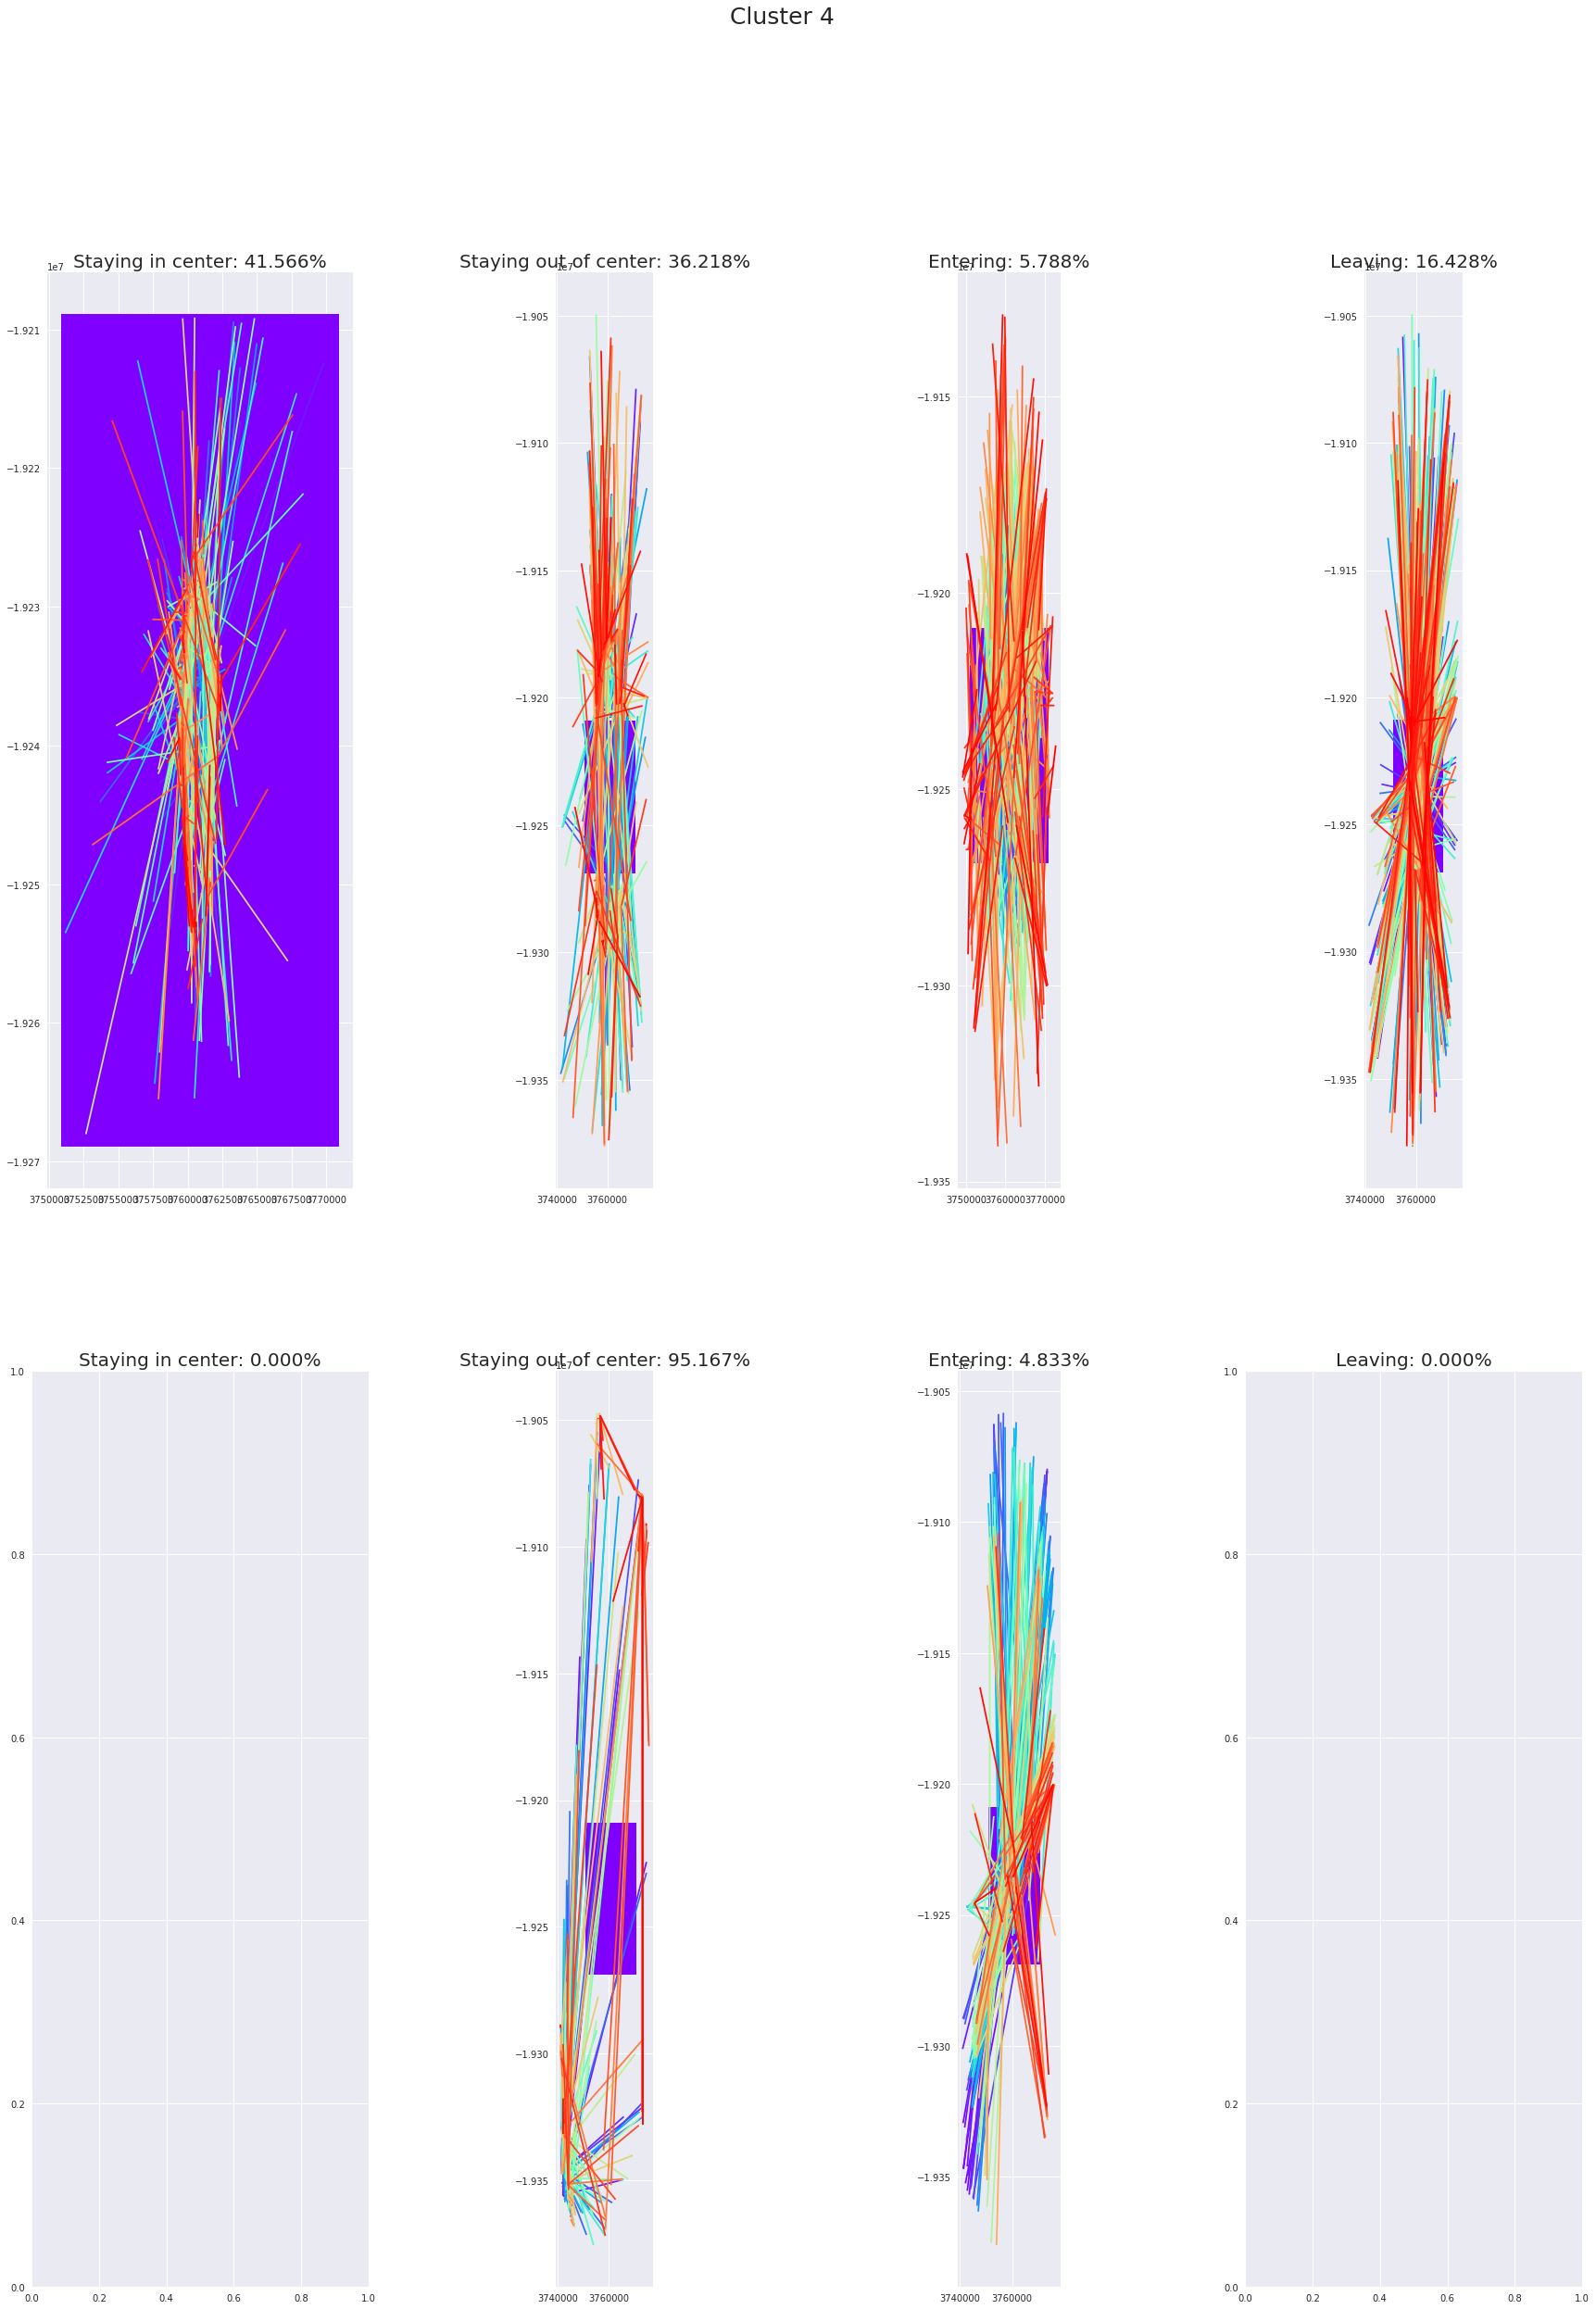

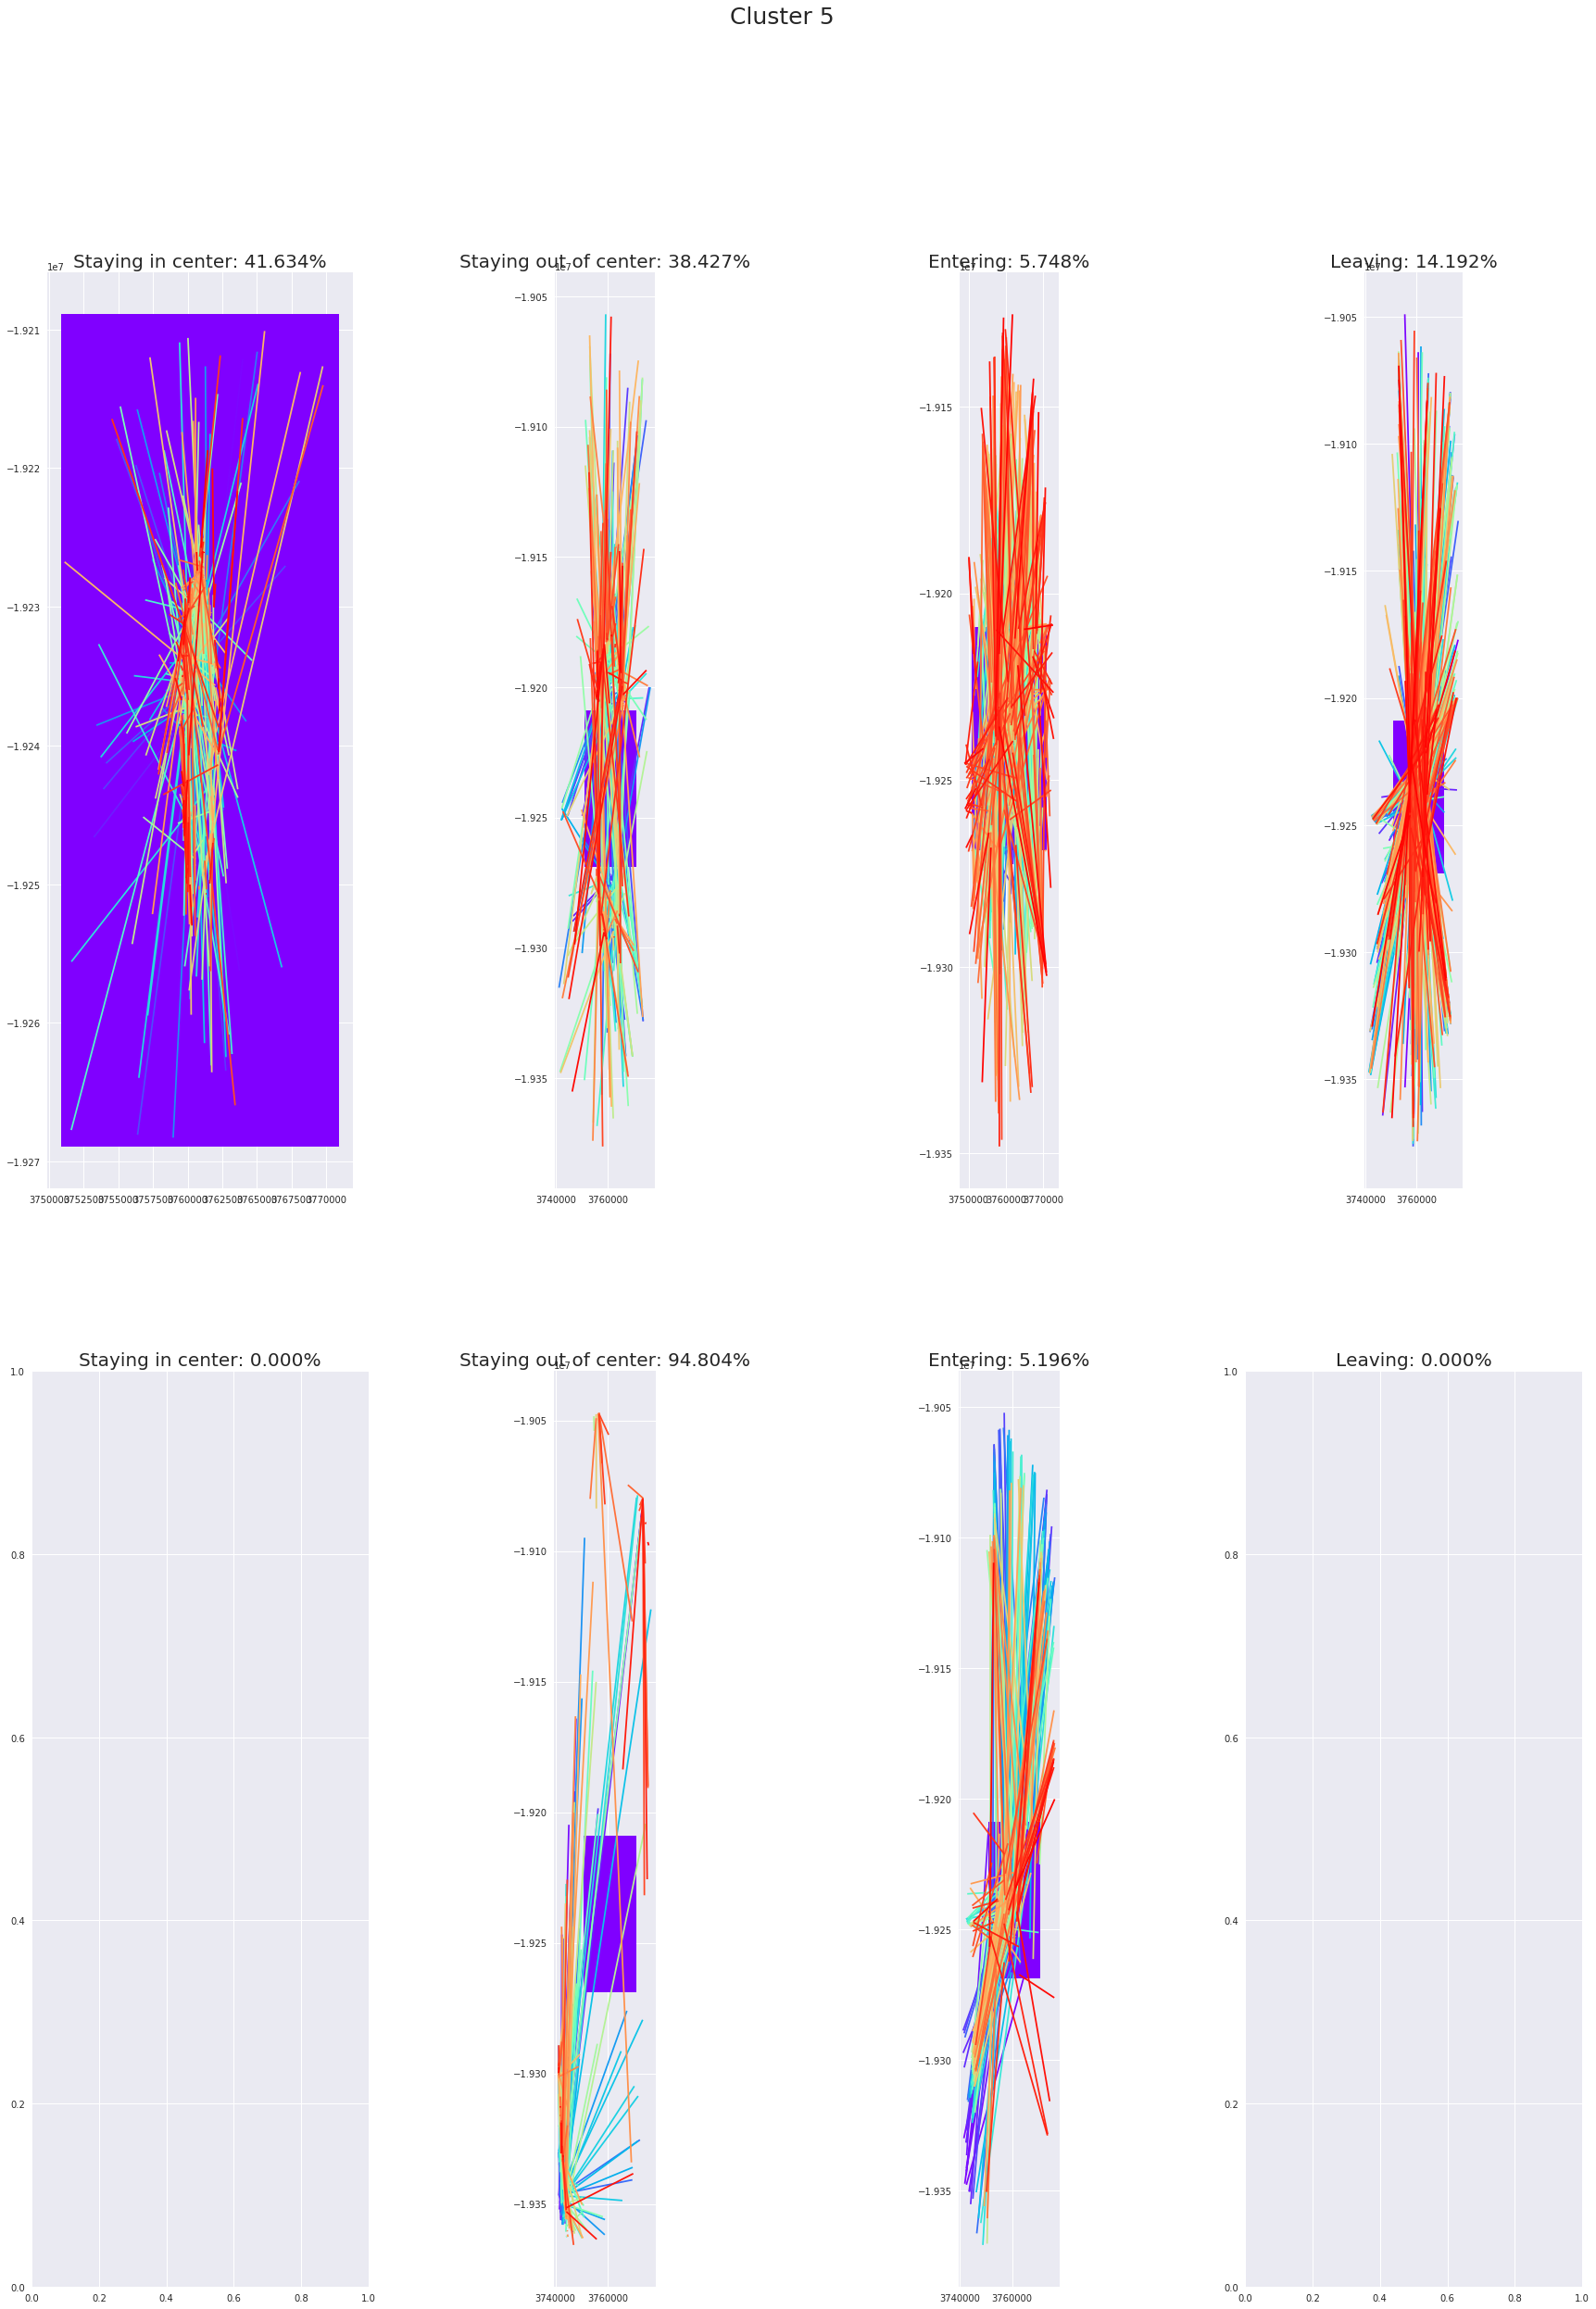

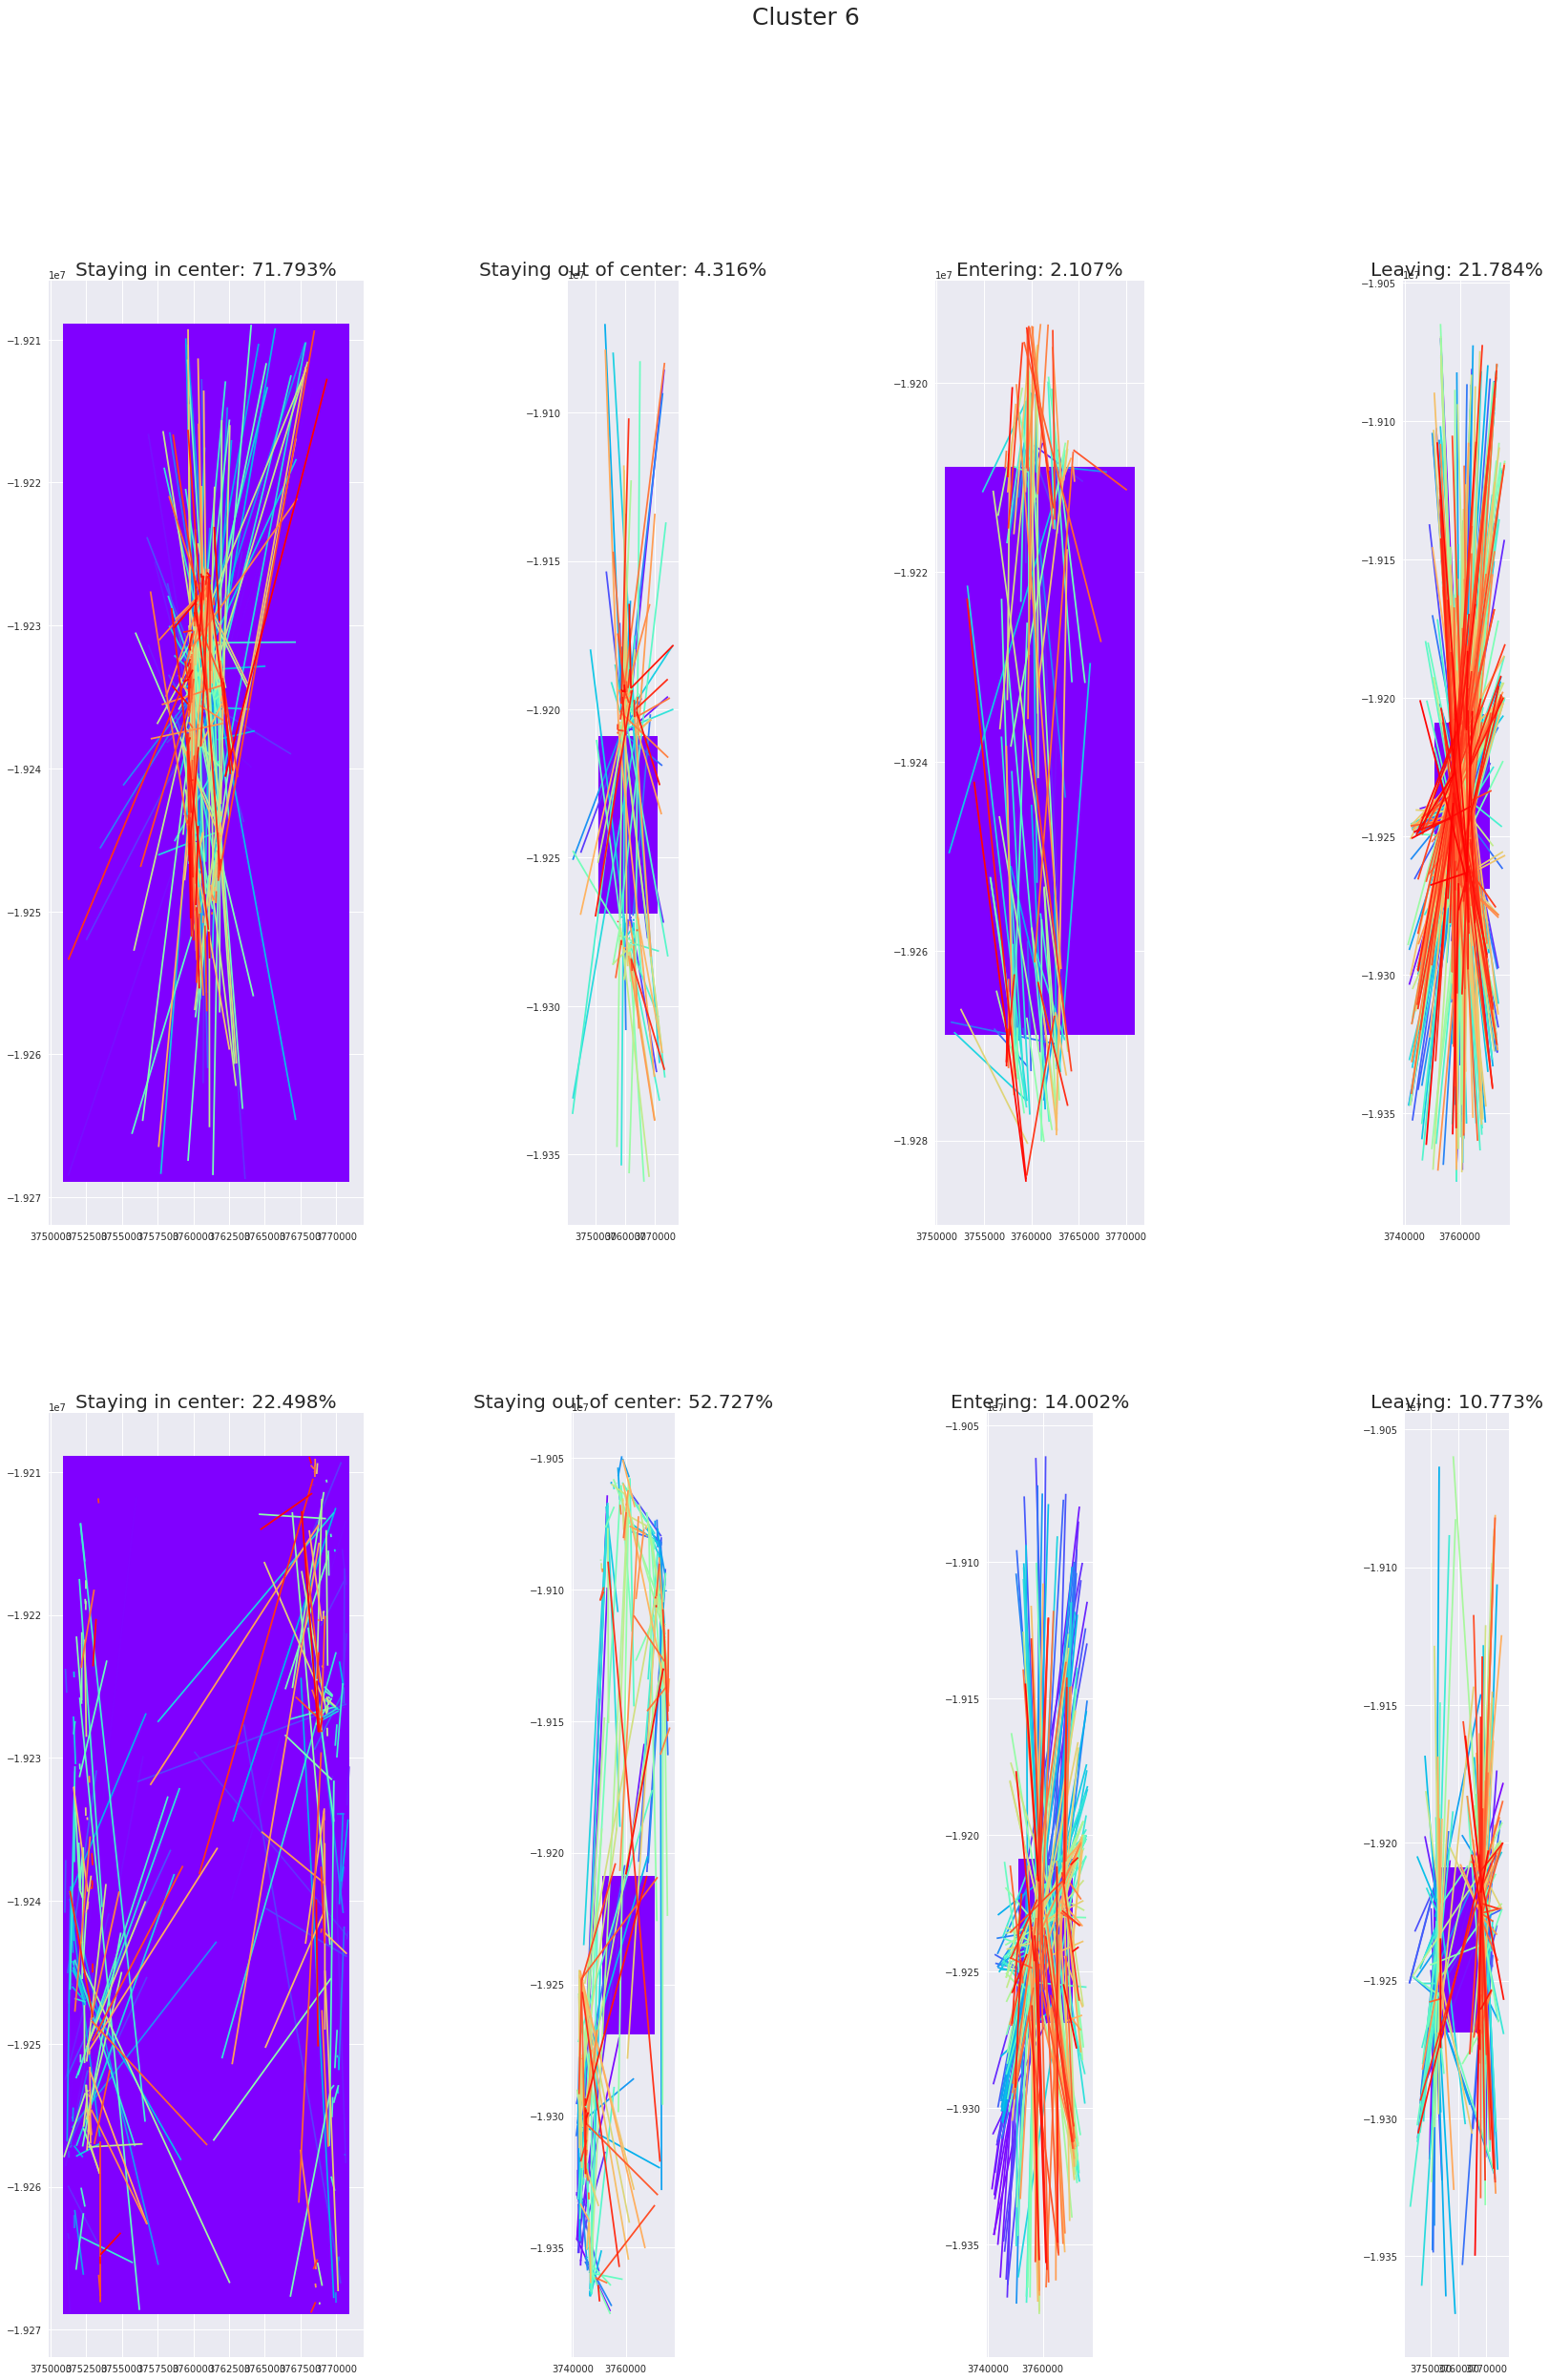

In [74]:
for i in cluster_range:
    cluster_plot(i, short_qtt=800, long_qtt=250)

In [113]:
data['cluster'] = kmeans.predict(scaler.transform(data[cluster_cols].fillna(0)))

# One Hot Encoding
onehot_clusters = pd.get_dummies(data.cluster, prefix='cluster')
data[onehot_clusters.columns] = onehot_clusters
data = data.drop(columns=['cluster'])

data.head(5)

hash  vmax_1  vmax_2  vmax_3     vmax_4  \
0   0000a8602cf2def930488dee7cdad104_1     NaN     NaN     NaN        NaN   
1   0000cf177130469eeac79f67b6bcf3df_9     NaN     NaN     NaN        NaN   
2   0001f97b99a80f18f62e2d44e54ef33d_3     NaN     NaN     NaN  32.196255   
3  0002124248b0ca510dea42824723ccac_31     NaN     NaN     NaN        NaN   
4  000219c2a6380c307e8bffd85b5e404b_23     NaN     NaN     NaN        NaN   

      vmax_5  vmin_1  vmin_2  vmin_3     vmin_4    ...      \
0        NaN     NaN     NaN     NaN        NaN    ...       
1   1.149404     NaN     NaN     NaN        NaN    ...       
2  30.167742     NaN     NaN     NaN  32.196255    ...       
3        NaN     NaN     NaN     NaN        NaN    ...       
4        NaN     NaN     NaN     NaN        NaN    ...       

   delta_origin_distance_lower_border_std  \
0                            71547.415715   
1                                     NaN   
2                                     NaN   
3                            41620.388213   
4                             3392.633683   

   delta_origin_distance_lower_border_median  count_trajectories  \
0                             -135225.195836                   5   
1                                        NaN                   1   
2                                   0.000000                   2   
3                              -29430.058741                   2   
4                               -1526.377896                   5   

   zeros_in_trajectory  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
0             0.166667          1          0          0          0          0   
1             0.750000          0          1          0          0          0   
2                  NaN          0          0          0          0          1   
3             0.777778          0          0          0          0          1   
4             0.250000          0          0          0          0          0   

   cluster_5  
0          0  
1          0  
2          0  
3          0  
4          1  

[5 rows x 1089 columns]

## <a id='5'>5. Model Training and Evaluation </a>

In [114]:
data_train = data[data['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 1089)

In [115]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 1089)

In [116]:
drop_cols = []

drop_cols += ['lat_lon_entry', 'lat_lon_exit']
drop_cols += ['euclidean_distance', 'manhattan_distance', 'harvesine_distance',
              'center_permanency', 'crossed_city', 'velocity', 'leaving_city', 'entering_city']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += list(x for x in data_train.columns if f'exit_{window_reference}' in x)# + grid_cols
drop_cols += list(x for x in data_train.columns if f'exit_entry_{window_reference}' in x)# + grid_cols
#drop_cols += [col+'_'+str(i) for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash', f'delta_last_center_permanency_{window_reference}', f'delta_origin_center_permanency_{window_reference}']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [117]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.3, random_state=423)
dt_train.shape, dt_test.shape

((46828, 1089), (20070, 1089))

In [118]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, random_state=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.7455352534324352

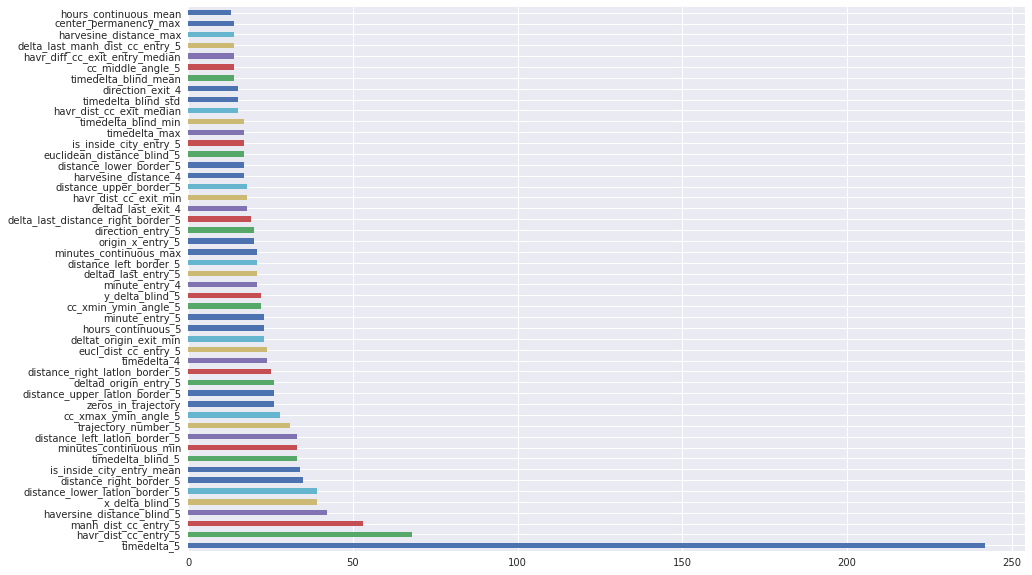

In [119]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [120]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

best_params_lgb = {'boosting_type': 'gbdt', 
                 'colsample_bytree': 1.0, 
                 'is_unbalance': False, 
                 'max_depth': 7, 
                 'n_estimators': 150, 
                 'num_leaves': 31, 
                 'objective': 'binary', 
                 'random_state': 20, 
                 'reg_alpha': 1, 
                 'subsample': 1}

clf = LGBMClassifier(**best_params_lgb)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.7447335811648078

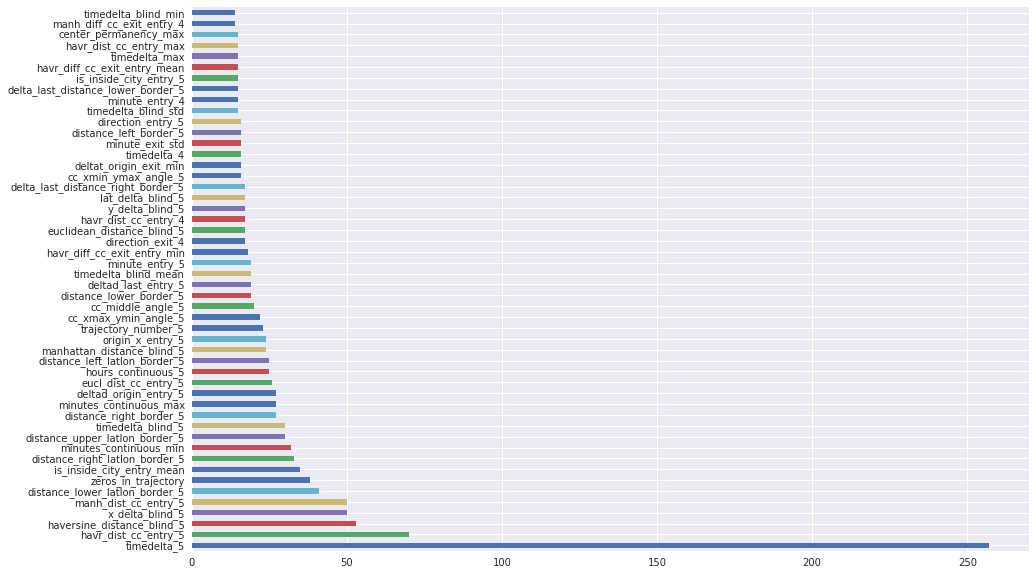

In [121]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [123]:
feat_importances_gb[[x for x in feat_importances_gb.index if 'cluster' in x]]

cluster_3    0
cluster_4    0
cluster_0    0
cluster_1    0
cluster_2    0
cluster_5    0
dtype: int64

In [166]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [167]:
data_test.shape

(33515, 713)

In [168]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [169]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [170]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [179]:
pd.Series(yhat).value_counts()

0.0    25034
1.0     8481
dtype: int64

In [172]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [173]:
submission.to_csv('../data/submission1_victor_julio.csv', index=False)

# Preprocessed Data Saving

In [46]:
data_sequence.to_hdf('../data/preprocessed/data_sequence.hdf', key='final', mode='w')